La idea es poder hacer un modelo de prediccion de precio para autos en base a la informacion proporcionada por el dataset de kaggle.
Este notebook se va a separar en las siguientes partes:
- Preparacion de dataset
- EDA
- Armado de la regresion
- Evaluacion del modelo
- Feature Engineer
- Regularizacion

##### Preparacion y EDA

In [10]:
# Importamos las librerias que nos van a servir en esta etapa del proceso
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data = "data.csv"

df = pd.read_csv(data)

In [9]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


Podemos ver que el dataset es bastante inconsistente con respecto al nombre de las columnas, donde varia el como viene separado el nombre (a veces con espacio y otras con "_"). Vamos a normalizar un poco el como se presentan las columnas. 
Para esto vamos a usar metodos para trabajar con strings y vamos a llevar todo a un formato de la forma *nombre_minuscula*, esto es lo que se conoce como **normalizar** el dataset.
Para normalizar usaremos lo que se conoce como metodos de str que nos permite hacer manipulacion de strings.

In [28]:
print("Columnas originales" )
print(df.columns)
print("Columnas trasnformadas" )
print(df.columns.str.lower().str.replace(" ","_"))

Columnas originales
Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')
Columnas trasnformadas
Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')


In [30]:
#Remplazo las columnas viejas por las nuevas
df.columns = df.columns.str.lower().str.replace(" ","_")

In [ ]:
#Hacemos lo mismo con los campos, pero primerop buscamos todos los campos que sean solo strings
df.dtypes # Nos interesa solamente el tipo "object"

In [36]:
columns = list(df.dtypes[df.dtypes == 'object'].index) # Esto nos deja saber cuales son las columnas que cumplen con este requisito

df[columns] = df[columns].apply(lambda x: x.str.lower().str.replace(" ","_"))

In [37]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


Ahora buscamos explorar un poco el dataset. Para esto vamos a estudiar  algunas cuestioens como valores unicos, cantidad de nulos, distribucion de precios, etc

In [ ]:
# Miramos algunos valores unicos para cada columna
for col in df.columns:
    print(col)
    print(df[col].unique()[:5]) # Lista algunos valores unicos
    print(df[col].nunique()) # Cantidad de valores unicos
    print()

Ahora buscamos visualizar la distribucion de los precios para poder hacernos una idea de lo que tenemos. Esto es importante porque el precio es el **target** de nuestro modelo.

<Axes: xlabel='msrp', ylabel='Count'>

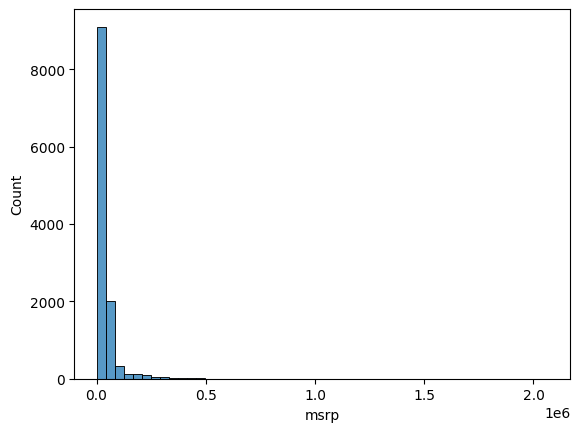

In [46]:
sns.histplot(df.msrp,bins = 50)

<Axes: xlabel='msrp', ylabel='Count'>

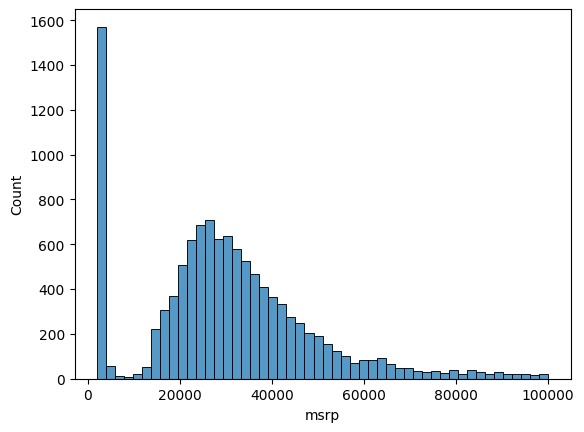

In [47]:
sns.histplot(df.msrp[df.msrp <100000],bins = 50)
#Podemos ver que la distribucion es mucho mas linda para trabajar, podemos ver que salvo por el disparo cerca del origen la distribucion es """casi""" gausianna.

Aca en el video lo que hacen es aplicar una escala logaritma para que la distribucion quede mas bonita, lo que hay que tener cuidado es que el valor arrojado por nuestro modelo luego estara en escala logaritmica y hay que revertir la transformacion.
Ademas tengo mis dudas sobre si esto afecta al rendimiento del modelo, eso me lo tengo que llevar para leer a ver si es asi.

In [48]:
#Pasamos los precios a escala logaritmica
price_log = np.log1p(df.msrp)

<Axes: xlabel='msrp', ylabel='Count'>

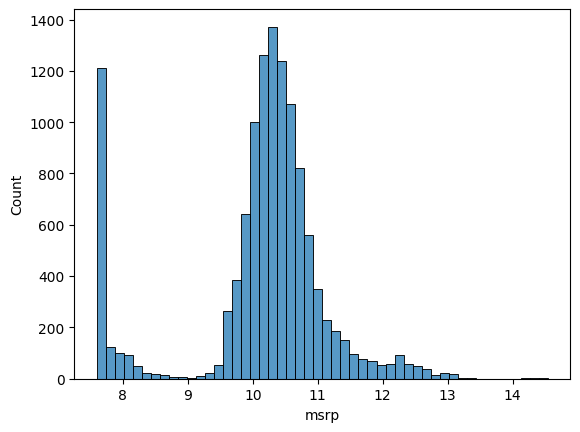

In [49]:
sns.histplot(price_log,bins = 50)
# La forma gaussiana ahora esta mucho mas pronunciada, ademas nos deshicimos de la cola enorme de outliners.
#Ahora la pregunta es que hacemos con el pico cerca del 0?

In [50]:
#Por ultimo chequeamos los null values a ver si esto podria traernos problemas.
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

##### Framework de validacion

Ahora que ya estuvimos jugando un poco con los valores y pudimos conocer un poco nuestro dataset es hora de empezar a pensar como podemos usarlo para validar nuestro modelo.
Vamos a usar un aproach donde:
- 60% train
- 20% validacion
- 20% test 
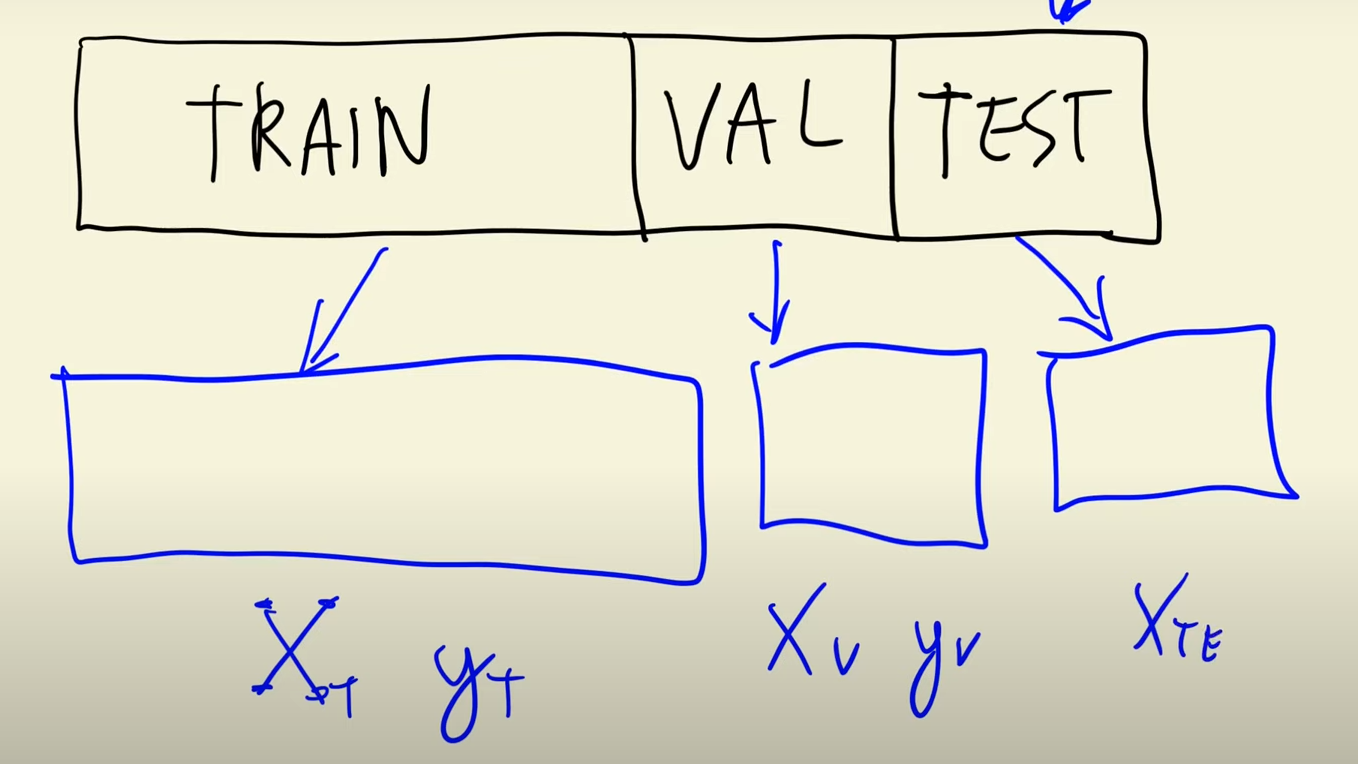

In [52]:
n = len(df) #cantidad de registros

n_val = int(n * 0.2)
n_test = int( n * 0.2)
n_train = n - n_val - n_test
# Esto es para no dejar ningun registro afuera en caso de que
# 2*int(n*0.2) + int(n * 0.6) != n

Ahora que ya tenemos la *cantidad de registros* que iran a parar a cada dataset lo que nos falta es crear dichos datasets, pero primero para asegurarnos una buena distribucion y evitar que los dataset sean muy homogeneos debemos tomar algun criterio para mezclarlos y/o partirlos.
En este curso, en este caso en particular lo que vamos a hacer es mezclar el index de los registros y luego particionar de esa manera.
Este metodo estoy seguro que es una mierda ya que no sigue ningun tipo de criterio detallado, pero para un primer aproach supongo que esta bien

In [ ]:
idx = np.arange(n) #Creo array de la cantidad de registros

In [55]:
np.random.shuffle(idx) 
#con esto lo que voy a hacer es tener un array de numeros ordenados de manera aleatoria que luego voy a utilizar para filtrar

In [56]:
df_train = df.iloc[idx[n_train:]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

Ahora si tomamos algunos de los datasets que creamos y lo chusmeamos vemos que los index que tiene son los heredamos del dataset original, por cuestiones de prolijidad (no esto seguro si hay alguna razon para conservar los originales) vamos a resetar los index para tener tres datasets como nuevitos y frescos para trabajar

In [58]:
df_test.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
4498,ford,f-150,2015,regular_unleaded,325.0,6.0,automatic,rear_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,26,19,5657,41670
1502,cadillac,ats_coupe,2016,premium_unleaded_(recommended),272.0,4.0,automatic,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,31,22,1624,47605
3340,mazda,cx-3,2016,regular_unleaded,146.0,4.0,automatic,front_wheel_drive,4.0,crossover,compact,4dr_suv,35,29,586,21960
180,mercedes-benz,300-class,1992,regular_unleaded,217.0,6.0,automatic,rear_wheel_drive,2.0,luxury,midsize,coupe,21,15,617,2248
7005,mazda,mpv,2006,regular_unleaded,200.0,6.0,automatic,front_wheel_drive,4.0,NaN,compact,passenger_minivan,23,16,586,28515


In [63]:
df_test = df_test.reset_index(drop= True)
df_train = df_train.reset_index(drop= True)
df_val = df_val.reset_index(drop= True)

In [65]:
#Ahora ya por fin nos generamos nuestro target para poder usarlo en la regresion

y_train = np.log1p(df_train.msrp.values)
y_test = np.log1p(df_test.msrp.values)
y_val = np.log1p(df_val.msrp.values)

#Borramos el precio de los DF originales para no usarlo por accidente y sesgar nuestro modelo
del df_test['msrp']
del df_train['msrp']
del df_val['msrp']

##### Regresion lineal